In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import files
uploaded = files.upload ()

Saving SeoulBikeData.csv to SeoulBikeData.csv


In [20]:
data = pd.read_csv('SeoulBikeData.csv', encoding='ISO-8859-1')


In [22]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = data.drop(columns=['Rented Bike Count', 'Date'])
y = data['Rented Bike Count']

# Perform the 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((7008, 12), (1752, 12), (7008,), (1752,))

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np


# Split the data into features (X) and target (y)
X = data.drop(columns=['Rented Bike Count', 'Date'])
y = data['Rented Bike Count']

# Perform the 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = ['Seasons', 'Holiday', 'Functioning Day']
numerical_cols = X.columns.difference(categorical_cols)

# Preprocessing for numerical data: scaling
numerical_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('mlp', MLPRegressor(hidden_layer_sizes=(2,),
                                             alpha=0.0001,
                                             max_iter=1000,
                                             random_state=42))])

# Train the neural network
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Initial RMSE: {rmse}')

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(2,), (5,), (10,), (5, 5)],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

# Define the grid search with reduced verbosity
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')


Initial RMSE: 398.33281658363245
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (5, 5)}
Best RMSE: 364.5637497927178


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best RMSE on Test Data: 360.09600330558504


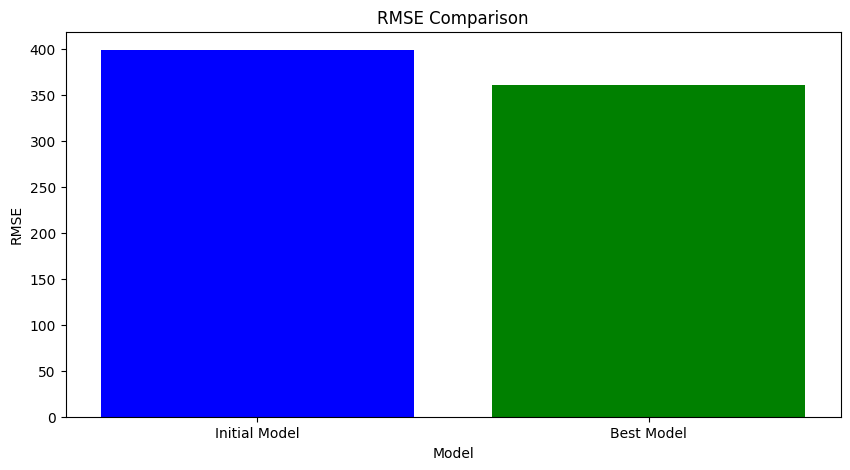

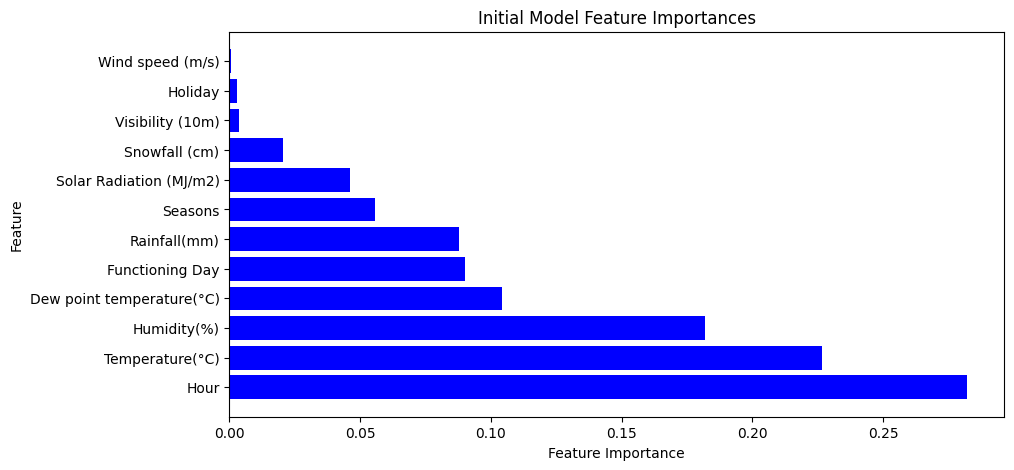

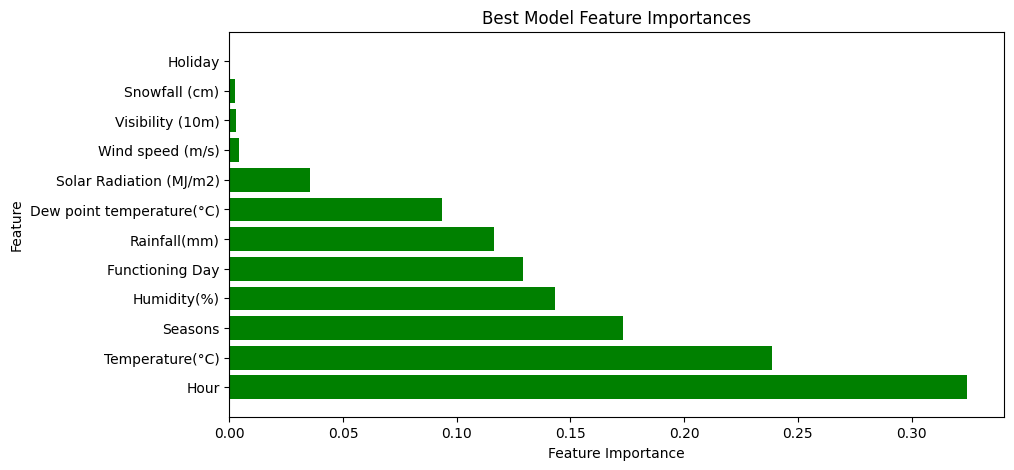

Initial Model Feature Importances: [0.28226092 0.22652909 0.18204278 0.00059179 0.00380299 0.10433325
 0.0459898  0.08782221 0.02068298 0.05586238 0.00296375 0.09011621]
Best Model Feature Importances: [0.32455045 0.23849062 0.14303675 0.00409576 0.00294816 0.09374304
 0.03549607 0.11659097 0.0026503  0.17296342 0.00050534 0.12897933]


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Rebuild the neural network with the best parameters
best_hidden_layer_sizes = best_params['mlp__hidden_layer_sizes']
best_alpha = best_params['mlp__alpha']

best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('mlp', MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes,
                                                  alpha=best_alpha,
                                                  max_iter=1000,
                                                  random_state=42))])

# Train the neural network
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Calculate RMSE for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f'Best RMSE on Test Data: {rmse_best}')

# Calculate permutation importance for the initial model
initial_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Calculate permutation importance for the best model
best_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.bar(['Initial Model', 'Best Model'], [rmse, rmse_best], color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.show()

# Plot feature importances for the initial model
initial_importances_mean = initial_importance.importances_mean
initial_feature_names = X.columns[initial_importance.importances_mean.argsort()[::-1]]

plt.figure(figsize=(10, 5))
plt.barh(initial_feature_names, initial_importances_mean[initial_importance.importances_mean.argsort()[::-1]], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Initial Model Feature Importances')
plt.show()

# Plot feature importances for the best model
best_importances_mean = best_importance.importances_mean
best_feature_names = X.columns[best_importance.importances_mean.argsort()[::-1]]

plt.figure(figsize=(10, 5))
plt.barh(best_feature_names, best_importances_mean[best_importance.importances_mean.argsort()[::-1]], color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Best Model Feature Importances')
plt.show()

# Display the results
print('Initial Model Feature Importances:', initial_importance.importances_mean)
print('Best Model Feature Importances:', best_importance.importances_mean)

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import graphviz



# Function to visualize the neural network
def plot_neural_network(layers):
    dot = graphviz.Digraph()
    dot.attr(rankdir='LR')

    # Add nodes for the input layer
    for i in range(len(X_train.columns)):
        dot.node(f'input_{i}', f'Input {i + 1}')

    # Add nodes for the hidden layers
    for l, size in enumerate(layers):
        for n in range(size):
            dot.node(f'hidden_{l}_{n}', f'Hidden {l + 1}-{n + 1}')
            if l == 0:  # first hidden layer
                for i in range(len(X_train.columns)):
                    dot.edge(f'input_{i}', f'hidden_{l}_{n}')
            else:  # subsequent hidden layers
                for n_prev in range(layers[l - 1]):
                    dot.edge(f'hidden_{l - 1}_{n_prev}', f'hidden_{l}_{n}')

    # Add nodes for the output layer
    dot.node('output', 'Output')
    for n in range(layers[-1]):
        dot.edge(f'hidden_{len(layers) - 1}_{n}', 'output')

    return dot

# Initial model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('mlp', MLPRegressor(hidden_layer_sizes=(2,),
                                             alpha=0.0001,
                                             max_iter=1000,
                                             random_state=42))])

# Train the initial model
model.fit(X_train, y_train)

# Make predictions with the initial model
y_pred = model.predict(X_test)

# Calculate RMSE for the initial model
rmse_initial = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Initial RMSE: {rmse_initial}')

# Plot the initial neural network
initial_nn_plot = plot_neural_network([2])
initial_nn_plot.render('initial_nn', format='png', view=True)


Initial RMSE: 398.33281658363245


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


'initial_nn.png'